<a href="https://colab.research.google.com/github/LukaT11/quantitative_finance/blob/master/Integration%2C_Cointegration%2C_and_Stationarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integration, Cointegration, and Stationarity**

In [0]:
!pip install quandl

In [0]:
import numpy as np
import pandas as pd
import quandl

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

## **Stationarity/Non-Stationarity**

A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [0]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

## Series **A**

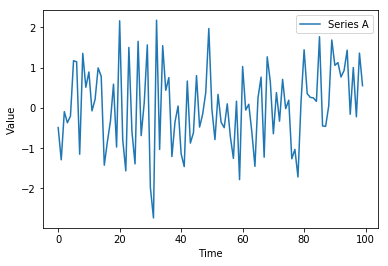

In [0]:
# Set the parameters and the number of datapoints
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])

## **Series B**

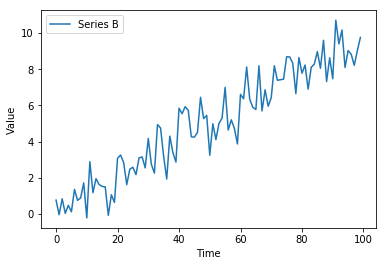

In [0]:
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
  params = (t * 0.1, 1)
  B[t] = generate_datapoint(params)
  
plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B'])

## **Why Non-Stationarity is Dangerous**

Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary $B$.

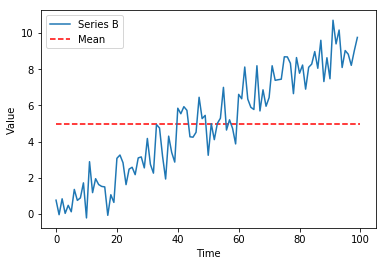

In [0]:
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean'])

The computed mean will show the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.

## **Testing for Stationarity**
Now we want to check for stationarity using a statistical test.

In [0]:
def check_for_stationarity(x, cutoff = 0.01):
  
  pvalue = adfuller(x)[1]
  if pvalue < cutoff:
    print(f'Pvalue: {pvalue}. Series {x.name} is likely stationary')
    return True
  else:
    print(f'Pvalue: {pvalue}. Series {x.name} is likely non-stationary')

In [0]:
check_for_stationarity(A)
check_for_stationarity(B)

Pvalue: 5.230908025501794e-05. Series A is likely stationary
Pvalue: 0.8203806181852368. Series B is likely non-stationary


Sure enough, the changing mean of the series makes it non-stationary. Let's try an example that might be a little more subtle.

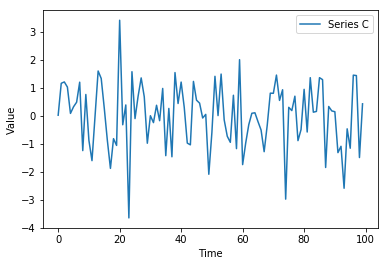

In [0]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C'])

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

In [0]:
check_for_stationarity(C)

Pvalue: 9.431534220914117e-05. Series C is likely stationary


True

##Order of Integration

###Moving Average Representation/Wold's Theorem

An important concept in time series analysis is moving average representation. Also check Wikipedia as listed below.

This representation expresses any time series $Y_t$ as 

$$Y_t = \sum_{j=0}^\infty b_j \epsilon_{t-j} + \eta_t$$

* $\epsilon$ is the 'innovation' series
* $b_j$ are the moving average weights of the innovation series
* $\eta$ is a deterministic series

The key here is as follows. $\eta$ is deterministic, such as a sine wave. Therefore we could perfectly model it. The innovation process is stochastic and there to simulate new information occuring over time. Specifically, $\epsilon_t = \hat Y_t - Y_t$ where $\hat Y_t$ is the in the optimal forecast of $Y_t$ using only information from time before $t$. In other words, the best prediction you can make at time $t-1$ cannot account for the randomness in $\epsilon$.

Each $b_j$ just says how much previous values of $\epsilon$ influence $Y_t$.


###Back to Order of Integration

We will note integration order-i as $I(i)$.

A time series is said to be $I(0)$ if the following condition holds in a moving average representation. In hand-wavy english, the autocorrelation of the series decays sufficiently quickly.

$$\sum_{k=0}^\infty |b_k|^2 < \infty$$

This property turns out to be true of all stationary series, but by itself is not enough for stationarity to hold. This means that stationarity implies $I(0)$, but $I(0)$ does not imply stationarity. For more on orders of integration, please see the following links.

https://en.wikipedia.org/wiki/Order_of_integration
https://en.wikipedia.org/wiki/Wold%27s_theorem

###Testing for $I(0)$

In practice testing whether the sum of the autocorrelations is finite may not be possible. It is possible in a mathematical derivation, but when we have a finite set of data and a finite number of estimated autocorrelations, the sum will always be finite. Given this difficulty, tests for $I(0)$ rely on stationarity implying the property. If we find that a series is stationary, then it must also be $I(0)$.

Let's take our original stationary series A. Because A is stationary, we know it's also $I(0)$.

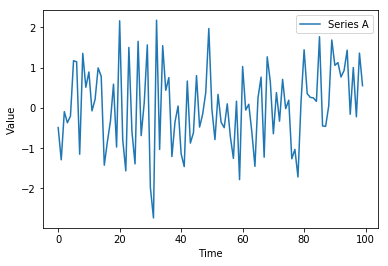

In [0]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A'])

###Inductively Building Up Orders of Integration

If one takes an $I(0)$ series and cumulatively sums it (discrete integration), the new series will be $I(1)$. Notice how this is related to the calculus concept of integration. The same relation applies in general, to get $I(n)$ take an $I(0)$ series and iteratively take the cumulative sum $n$ times.

Now let's make an $I(1)$ series by taking the cumulative sum of A.

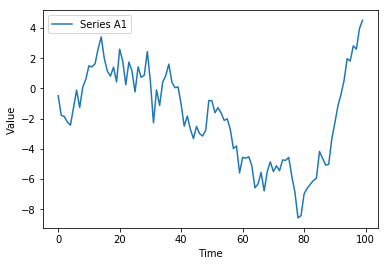

In [0]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1'])

Now let's make one $I(2)$ by taking the cumlulative sum again.

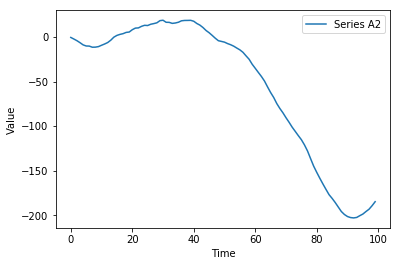

In [0]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2'])

###Breaking Down Orders of Integration

Conversely, to find the order of integration of a given series, we perform the inverse of a cumulative sum, which is the $\Delta$ or itemwise difference function. Specifically

$$(1-L) X_t = X_t - X_{t-1} = \Delta X$$

$$(1-L)^d X_t$$

In this case $L$ is the lag operator. Sometimes also written as $B$ for 'backshift'. $L$ fetches the second to last elements in a time series, and $L^k$ fetches the k-th to last elements. So 

$$L X_t = X_{t-1}$$

and

$$(1-L) X_t = X_t - X_{t-1}$$

A series $Y_t$ is $I(1)$ if the $Y_t - Y_t-1$ is $I(0)$. In other words, if you take an $I(0)$ series and cumulatively sum it, you should get an $I(1)$ series.


###Important Take-Away

Once all the math has settled, remember that any stationary series is $I(0)$